In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression as Logistic
# from sklearn.metrics import accuracy_score, label_ranking_average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter, OrderedDict
import os

from utils.utils import *
from utils.utils_baseline_svm import *

from utils.kwargs_file import kwargs_lin_data_init, kwargs_svm, kwargs_logistic

In [198]:
# call for linear model
# change data preprocessing hyper-parameters
kwargs_lin_data_init.mk_ngrams = True   # True / False
kwargs_lin_data_init.char_filter = 2  # 100 / 2
kwargs_lin_data_init.ngram_filter = 2  # 10 / 2

kwargs_lin_data_init.use_suggestions = '0.8'  # '0.7' / '0.8' / '0.9' / False

# for writing the results to file
sub_folder = 'svm_results/'

# summary_path = 'SVM_hyperparameter_summary_suggest_09_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_09_only_BOC_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_09_WITH_NGRAMS_6_1.csv'

summary_path = 'SVM_hyperparameter_summary_suggest_08_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_08_only_BOC_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_08_WITH_NGRAMS_6_1.csv'

# summary_path = 'SVM_hyperparameter_summary_suggest_07_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_07_only_BOC_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_07_WITH_NGRAMS_6_1.csv'

# summary_path = 'SVM_hyperparameter_summary_no_suggest_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_no_suggest_only_BOC_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_no_suggest_WITH_NGRAMS_6_1.csv'
summary_path = sub_folder + summary_path

In [199]:
# vectorizer transforms dict into sparse matrix
v = DictVectorizer(sparse=True)

x_train, x_val, y_train, y_val, allowed_ngrams = \
    data_load_preprocess(**kwargs_lin_data_init)

Using label suggestion data with similarity threshold of 0.8
The are 3565 observations
Sampling from allowed 96 labels
96 labels in the validation set, with
2111 potential observation to draw from.
480 observations sampled for validation
1631 observations for training
The ratio of validation to *training* is about 0.294


In [200]:
# x_train, x_val, y_train, y_val, allowed_ngrams = \
#     data_load_preprocess(**{**kwargs_lin_data_init, 
#                             **{'linear_counters': False}})

# keep_first_k_chars(input=x_train, k=4, 
#                    model='linear', 
#                    ngram_width=kwargs_lin_data_init.ngram_width, 
#                    mk_ngrams=kwargs_lin_data_init.mk_ngrams, 
#                    allowed_ngrams=allowed_ngrams)

In [201]:
# create a sparse X matrix with character and n-grams features
X_train = v.fit_transform(x_train)
X_val = v.transform(x_val)

# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html

print('X_train (sparse) matrix, of size {} by {} has been created.'
      .format(X_train.get_shape()[0], X_train.get_shape()[1]))  # vectorized

svm_clf = svm.SVC(**kwargs_svm)

X_train (sparse) matrix, of size 1631 by 6092 has been created.


In [202]:
svm_clf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2178, shrinking=True,
  tol=0.001, verbose=False)

In [203]:
pred = svm_clf.predict(X_val)

# http://scikit-learn.org/stable/modules/svm.html
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# print(accuracy_score(y_val, pred))
# equivalent to:
print('Accuracy on validation set is {:.3f}'.format(svm_clf.score(X_val, y_val)))
# print(pred[:10])

# array to hold log probabilities (takes a bit longer to calc)
pred_prob = svm_clf.predict_log_proba(X_val)
# makes y into array with the same shape as the log prob
y_val_dense = y_to_dense(y=y_val, 
                         classes=svm_clf.classes_)

Accuracy on validation set is 0.979


In [ ]:
k = 5
'{:.3f} of observations has the correct class in the top {} prediction'.format(
    in_top_k(y_val_dense, pred_prob, k), k)

print('Mean Reciprocal Rank is {:.3f}'.format(mean_reciprocal_rank(y_val_dense, pred_prob)))

In [ ]:
# logistic regression

logistic_clf = Logistic(**kwargs_logistic)
logistic_clf.fit(X_train, y_train)

In [ ]:
pred_logistic = logistic_clf.predict(X_val)
print('Accuracy on validation set is {:.3f}'.format(svm_clf.score(X_val, y_val)))

In [ ]:
"""
Train multiple classifiers with different hyper-parameters.
"""

In [204]:
k = 5  # for the top_k metric

summary_to_file = []

for kernel, degree in zip(
    ['linear', *['poly'] * 3, 'rbf', 'sigmoid'], 
    [3, *list(range(2, 2+3)), 3, 3]):
    for C in [0.01, 0.1, 1.0]: 
        for shrinking in [True, False]:
            kwargs_cur_params = {**kwargs_svm, 
                                 **{'kernel': kernel, 
                                    'degree': degree, 
                                    'C': C,
                                    'shrinking': shrinking}}
            
            # clearing all vars (just making sure)
            svm_cur = ''
            pred_cur = ''
            pred_prob_cur = ''
            y_val_dense_cur = ''
            cur_acc, cur_topk, cur_mrr = '', '', ''
            summary_cur_model, summary_dict = '', ''

            # create and fit model
            svm_cur = svm.SVC(**kwargs_cur_params)
            svm_cur.fit(X_train, y_train)
            # predictions
            pred_cur = svm_cur.predict(X_val)
            # log probabilities
            pred_prob_cur = svm_cur.predict_log_proba(X_val)
            # makes y into array with the same shape as the log prob
            # get dense y again, not sure if classes are always ordered the same
            y_val_dense_cur = y_to_dense(y=y_val, 
                                         classes=svm_cur.classes_)
            # collect evaluation metrics
            cur_acc, cur_topk, cur_mrr = \
                in_top_k(y_val_dense_cur, pred_prob_cur, 1), \
                in_top_k(y_val_dense_cur, pred_prob_cur, k), \
                mean_reciprocal_rank(y_val_dense, pred_prob_cur)
            
            summary_to_file.append(OrderedDict(
                sorted(tuple((k,v) for k,v in svm_cur.get_params().items() 
                             if k not in ['class_weight', 
                                          'cache_size', 
                                          'max_iter', 
                                          'random_state', 
                                          'tol', 
                                          'verbose'])) + \
                [('Accuracy', '{:.3f}'.format(cur_acc)), 
                 ('Mean Reciprocal Rank', '{:.3f}'.format(cur_mrr)), 
                 ('Top {}'.format(k), '{:.3f}'.format(cur_topk))]
            ))
            
            print('Model fitted: {}'.format(svm_cur))
            print('Accuracy on test set is {:.3f}'.format(cur_acc))
            print('{:.3f} of observations has the correct class in the top {} prediction'.format(
                cur_topk, k))
            print('Mean Reciprocal Rank is {:.3f}'.format(cur_mrr))

Model fitted: SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2178, shrinking=True,
  tol=0.001, verbose=False)
Accuracy on test set is 0.948
0.983 of observations has the correct class in the top 5 prediction
Mean Reciprocal Rank is 0.963
Model fitted: SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2178, shrinking=False,
  tol=0.001, verbose=False)
Accuracy on test set is 0.948
0.983 of observations has the correct class in the top 5 prediction
Mean Reciprocal Rank is 0.963
Model fitted: SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2178, shrinking=True,
  tol=0.001, verbose=False)
Accuracy on test s

In [205]:
results_df = pd.DataFrame(summary_to_file)
results_df.sort_values(by='Mean Reciprocal Rank', 
                       ascending=False, 
                       inplace=True)

results_df

,C,coef0,decision_function_shape,degree,gamma,kernel,probability,shrinking,Accuracy,Mean Reciprocal Rank,Top 5
2,0.10,0.0,ovr,3,auto,linear,True,True,0.958,0.971,0.988
3,0.10,0.0,ovr,3,auto,linear,True,False,0.958,0.971,0.988
4,1.00,0.0,ovr,3,auto,linear,True,True,0.958,0.971,0.988
5,1.00,0.0,ovr,3,auto,linear,True,False,0.958,0.971,0.988
0,0.01,0.0,ovr,3,auto,linear,True,True,0.948,0.963,0.983
1,0.01,0.0,ovr,3,auto,linear,True,False,0.948,0.963,0.983
29,1.00,0.0,ovr,3,auto,rbf,True,False,0.542,0.622,0.681
28,1.00,0.0,ovr,3,auto,rbf,True,True,0.542,0.622,0.681
34,1.00,0.0,ovr,3,auto,sigmoid,True,True,0.438,0.539,0.623
35,1.00,0.0,ovr,3,auto,sigmoid,True,False,0.438,0.539,0.623


In [206]:
# save to file
results_df.to_csv(summary_path)

In [64]:
"""
Load training results from CSV files
"""

'\nLoad training results from CSV files\n'

In [65]:
# get a list of file names in sub_folder
summary_files = [fname
                 for fname 
                 in next(os.walk(sub_folder))][2]

summary_files = [sub_folder + fname 
                 for fname in summary_files]

In [66]:
results = []
for file in summary_files:
    data_table = pd.read_csv(file)
    row = OrderedDict()
    row['name'] = file.split('summary_')[1]  # split the file name
    row['Accuracy'] = data_table['Accuracy'][0]
    row['Mean Reciprocal Rank'] = data_table['Mean Reciprocal Rank'][0]
    row['kernel'] = data_table['kernel'][0]
    row['c'] = data_table['C'][0]
    results.append(row)

In [148]:
results_summary = pd.DataFrame(results)
results_summary = \
    results_summary.sort_values(by='name', ascending=False)

In [116]:
plt.clf()

([<matplotlib.axis.XTick at 0x7f6ac37a5fd0>,
 <a list of 12 Text xticklabel objects>)

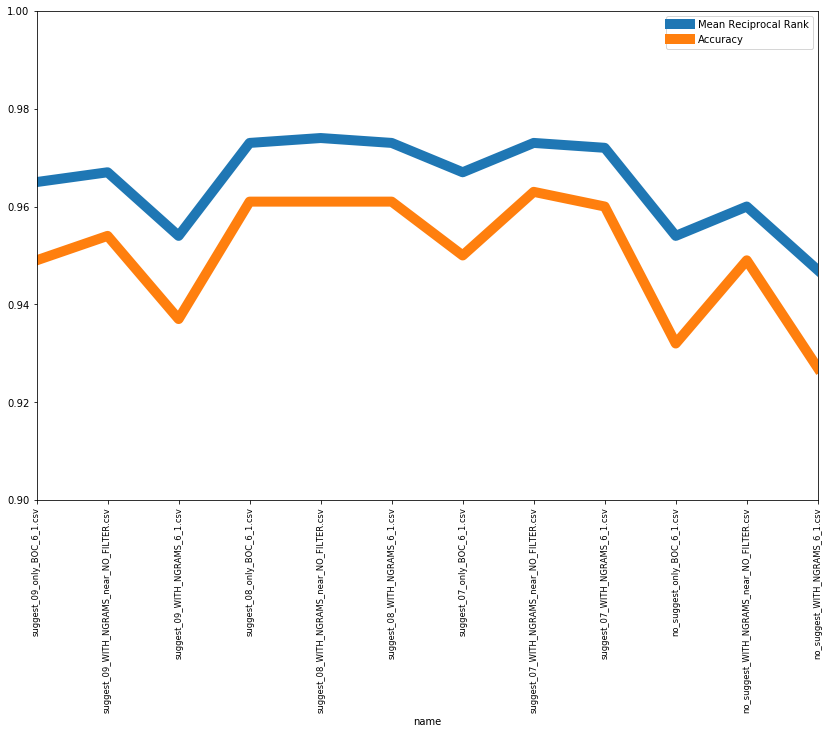

In [119]:
ax = results_summary.plot(x='name', 
                       y=['Mean Reciprocal Rank', 
                          'Accuracy'], 
                       figsize=(14,9),
                       rot=90, 
                       ylim=(0.9, 1.0), 
                       linewidth=10, 
                       kind='line')

x_tick_len = len(results_summary)
# ax.xaxis.set_ticks(np.arange(0, x_tick_len+1))
# ax.xaxis.set_label(np.arange(0, x_tick_len+1))
# ax.xaxis.set_label('name')

# plt.setp(ax.get_xticklabels(), visible=True)

# plt.xticks(range(len(data3)), x_axis, size='small')
plt.xticks(range(x_tick_len), results_summary['name'], size='small')